In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
import torch.optim as optim
import torchmetrics

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
trnsfrms = T.Compose(
    [
        T.Resize((224, 224)),
        #T.RandomHorizontalFlip(),
        #T.RandomRotation(15),
        #T.RandomPerspective(),
        T.ToTensor() # автоматически интервал пикселей будет 0-1
    ]
)

In [3]:
train_dataset = torchvision.datasets.ImageFolder(
    './data/archive_blood/TRAIN',
    transform=trnsfrms
)
valid_dataset = torchvision.datasets.ImageFolder(
    './data/archive_blood//TEST',
    transform=trnsfrms
)

In [4]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}

In [5]:
idx2class

{0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

In [6]:
df_labels = pd.DataFrame.from_dict(idx2class, orient='index')
df_labels

,0
0,EOSINOPHIL
1,LYMPHOCYTE
2,MONOCYTE
3,NEUTROPHIL


In [7]:
df_labels.to_csv('./models/model_blood/data_labels.csv', index=False, encoding='utf-8')

In [8]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True)

In [9]:
if torch.cuda.is_available():
    print("CUDA доступна!")
    device = torch.device("cuda")
else:
    print("CUDA недоступна. Вычисления будут выполняться на CPU.")
    device = torch.device("cpu")

CUDA доступна!


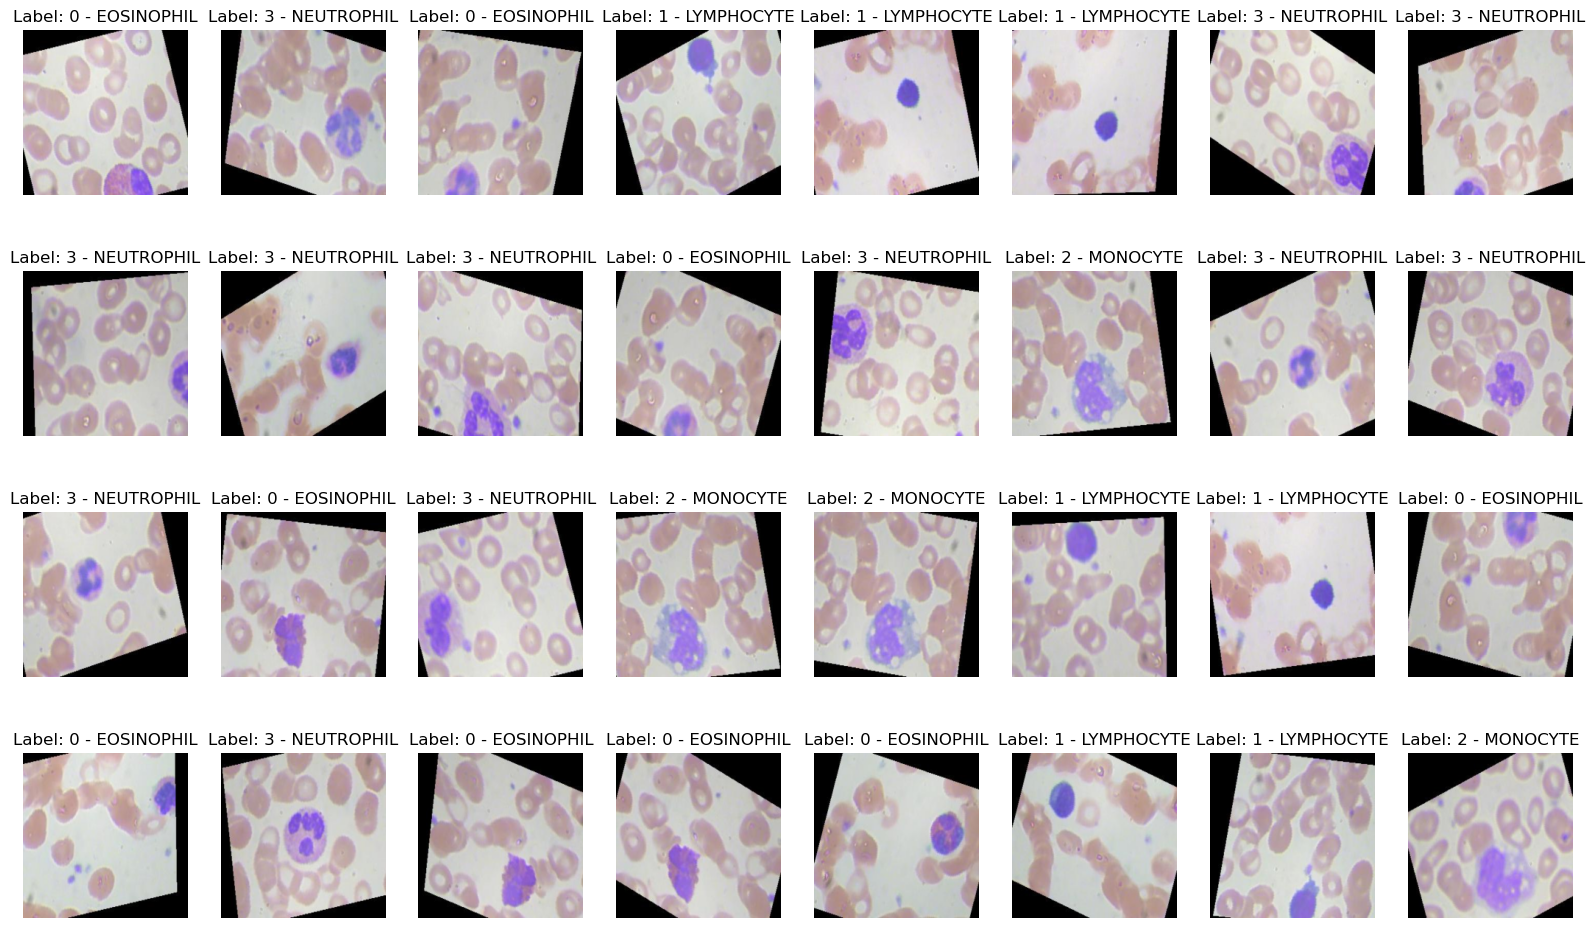

In [10]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch

for i, plot in enumerate(ax):
    label_index = test_targets[i].item()
    plot.set_title(f'Label: {label_index} - {valid_loader.dataset.classes[label_index]}')

    # Проверяем количество каналов
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    elif test_samples[i].shape[0] == 1:  # Если 1 канал (оттенки серого)
        img = test_samples[i][0, :, :]  # Оставляем как есть
    else:
        raise ValueError("Неизвестное количество каналов")

    plot.imshow(img.cpu())  # Используем imshow() для цветных изображений
    plot.axis('off')

plt.show()

In [11]:
def fit(
        model: torch.nn.Module,
        n_epochs: int,
        optimizer: torch.optim.Optimizer,
        criterion,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        ) -> tuple[list, ...]:

    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4).to(device)  # Инициализируем torchmetrics.Accuracy

    train_losses = []
    valid_losses = []
    train_metrics = []
    valid_metrics = []
    time_metrics = []

    for epoch in range(n_epochs):
        start = datetime.datetime.now()
        
        model.train()

        train_loss_epoch = []
        train_metric_epoch = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)  # Используем переданный criterion

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = accuracy(outputs, labels)  # Используем torchmetrics.Accuracy
            train_loss_epoch.append(loss.item())
            train_metric_epoch.append(acc.item())

        model.eval()

        valid_loss_epoch = []
        valid_metric_epoch = []

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)  # Получаем выходы модели

            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            valid_loss_epoch.append(loss.item())
            valid_metric_epoch.append(acc.item())

        epoch_train_loss = np.mean(train_loss_epoch)
        epoch_train_metric = np.mean(train_metric_epoch)

        epoch_valid_loss = np.mean(valid_loss_epoch)
        epoch_valid_metric = np.mean(valid_metric_epoch)

        time = (datetime.datetime.now() - start).total_seconds()
        time_metrics.append(round(time))
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        train_metrics.append(epoch_train_metric)
        valid_metrics.append(epoch_valid_metric)
        

        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_metric:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {epoch_valid_metric:.4f}")

        
    return train_losses, valid_losses, train_metrics, valid_metrics, time_metrics

In [12]:
#from torchvision.models import resnet18, ResNet18_Weights

#model_lrs = resnet18(weights="DEFAULT")

In [15]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

model_eff = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /home/sergei/snap/jupyterlab-desktop/common/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:44<00:00, 1.11MB/s]


In [16]:
tu.get_model_summary(model_eff.to(device), test_samples[1].unsqueeze(0).to(device))

Layer                                                     Kernel               Output          Params          FLOPs
0_features.0.Conv2d_0                                    [3, 40, 3, 3]    [1, 40, 112, 112]       1,080   13,547,520
1_features.0.BatchNorm2d_1                                        [40]    [1, 40, 112, 112]          80    2,007,040
2_features.0.SiLU_2                                                  -    [1, 40, 112, 112]           0            0
3_features.1.0.block.0.Conv2d_0                          [1, 40, 3, 3]    [1, 40, 112, 112]         360    4,515,840
4_features.1.0.block.0.BatchNorm2d_1                              [40]    [1, 40, 112, 112]          80    2,007,040
5_features.1.0.block.0.SiLU_2                                        -    [1, 40, 112, 112]           0            0
6_features.1.0.block.1.AdaptiveAvgPool2d_avgpool                     -        [1, 40, 1, 1]           0      501,800
7_features.1.0.block.1.Conv2d_fc1                       [40, 10,

In [15]:
for param in model_lrs.parameters():
    param.requires_grad = False

In [17]:
for i, param in enumerate(model_eff.parameters()):
    print(i, param.requires_grad)

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 True
122 True
123

In [17]:
model_lrs.fc[1]

Linear(in_features=512, out_features=4, bias=True)

In [18]:
model_lrs.fc[1].weight.requires_grad = True
model_lrs.fc[1].bias.requires_grad = True

model_lrs.layer4[0].conv2.weight.requires_grad = True
model_lrs.layer4[0].bn2.weight.requires_grad = True
model_lrs.layer4[0].bn2.bias.requires_grad = True

model_lrs.layer4[0].downsample[0].weight.requires_grad = True
model_lrs.layer4[0].downsample[1].weight.requires_grad = True
model_lrs.layer4[0].downsample[1].bias.requires_grad = True

model_lrs.layer4[1].conv1.weight.requires_grad = True
model_lrs.layer4[1].bn1.weight.requires_grad = True
model_lrs.layer4[1].bn1.bias.requires_grad = True

model_lrs.layer4[1].conv2.weight.requires_grad = True
model_lrs.layer4[1].bn2.weight.requires_grad = True
model_lrs.layer4[1].bn2.bias.requires_grad = True

In [19]:
for param in model_lrs.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [20]:
criterion_lrs = nn.CrossEntropyLoss()
optimizer_lrs = optim.Adam(model_lrs.parameters(), lr=0.0005)

In [21]:
model_lrs.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
history = None

In [23]:
torch.cuda.empty_cache()

In [ ]:
%%time
start = datetime.datetime.now()
print('Время старта: ' + str(start))

model_lrs.to(device)

model_data = fit(n_epochs=30, model=model_lrs, optimizer=optimizer_lrs, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion_lrs)

finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# вычитаем время старта из времени окончания
print('Время : ' + str(finish - start))

In [25]:
#torch.save(model_lrs, './models/model_blood/model_blood.pth')

In [26]:
#torch.save(model_lrs.state_dict(), './models/model_sport/model_weights.pth')

In [27]:
train_losses, valid_losses, train_metric, valid_metric, time = model_data

NameError: name 'model_data' is not defined

In [ ]:
data_metrics = np.array([
    train_losses, valid_losses, train_metric, valid_metric, time
])

df = pd.DataFrame(data_metrics.T, columns=['train_losses', 'valid_losses', 'train_metric', 'valid_metric', 'time'])
df

In [ ]:
#df.to_csv('./models/model_sport/data.csv', index=False, encoding='utf-8')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(train_losses, label='Train loss')
ax[0].plot(valid_losses, label='Valid Loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[0].set_ylim((0, max(train_losses+valid_losses)+.1))

ax[1].plot(train_metric, label='Train accuracy')
ax[1].plot(valid_metric, label='Valid accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].set_ylim((0, max(train_metric+valid_metric)+.1))

In [ ]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten() # переводим в одномерный массив
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch
test_samples = test_samples.to(device)
for i, plot in enumerate(ax):
    label_index = test_targets[i].item()  # Получаем индекс метки из тестового набора
    y_pred = torch.argmax(model_lrs(test_samples[i].unsqueeze(0)))
    y_pred = y_pred.cpu().detach().numpy()
    color = 'r' if y_pred != label_index else 'g'
    plot.set_title(f'  Label: {label_index} - {train_loader.dataset.classes[label_index]}\n'
                   f'Predict: {y_pred} - {train_loader.dataset.classes[y_pred]}', color=color)
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    plot.imshow(img.cpu())#plot.matshow(test_samples[i][0, :, :].cpu().detach().numpy(), cmap='gray')
    plot.axis('off')